# Training of UNET

The aim of this notebook is to train two times the UNET model, once using the training data with simple data augmentations (rotation by multiples of 90 degrees, horizontal and vertical flips), and the second time with said data augmentation and distortions added to the training data (non-uniform illumination and gaussian noise).

### $\bullet$ Importing libraries and utilitary functions

In [1]:
# Import python libraries.
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
%load_ext autoreload
%autoreload 2
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import tensorflow
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Import utilitary functions and module defining the Unet model.
from utils import get_dataset_from_folders
from train_data_augmentation import make_train_generator
from unet import unet
from distortions import add_gaussian, add_gaussian_noise
from plots import plot_history

In [2]:
# Set seeds of random number generators to guarantee reproducibility.
np.random.seed(1)
tensorflow.random.set_seed(2)

### $\bullet$ Setting size of the input image and different paths

In [3]:
# Shape of the inputs of the deep network.
images_shape = (256, 256, 1)

# Variables defining the path to the dataset.
train_input_path  = '../Dataset/train/input/'
train_output_path = '../Dataset/train/output/'
val_input_path    = '../Dataset/validation/input/'
val_output_path   = '../Dataset/validation/output/'
test_input_path   = '../Dataset/test/input/'
test_output_path  = '../Dataset/test/output/'

# Variable defining where models will be stored.
unet_original_save_path       = "../Unet Original/"
unet_data_augmented_save_path = "../Unet Data Augmented/"
unet_data_distorted_save_path = "../Unet Data Distorted/"

### $\bullet$ Load images from the dataset

In [4]:
train_images, train_masks = get_dataset_from_folders(train_input_path, train_output_path, images_shape)
val_images, val_masks = get_dataset_from_folders(val_input_path, val_output_path, images_shape)
test_images, test_masks = get_dataset_from_folders(test_input_path, test_output_path, images_shape)

print(f'Training set contains {len(train_images)} images.')
print(f'Validation set contains {len(val_images)} images.')
print(f'Test set contains {len(test_images)} images.')

Training set contains 606 images.
Validation set contains 96 images.
Test set contains 510 images.


### $\bullet$ Training original model which used no data augmentations

In [5]:
# Setting up parameters used for training
number_epochs = 100
batch_size = 2
early_stopping = EarlyStopping(patience=50, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath=unet_original_save_path, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)

# Building Unet model.
unet = unet(images_shape, show_summary=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [6]:
# Training
history = unet.fit(train_images, train_masks, validation_data = (val_images, val_masks), batch_size = batch_size, epochs=number_epochs, callbacks=[early_stopping, model_checkpoint])

Train on 606 samples, validate on 96 samples
Epoch 1/100
602/606 [============================>.] - ETA: 0s - loss: 0.8847 - accuracy: 0.9412 ETAWARNING:tensorflow:From C:\Anaconda3\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ../Model Original/assets
606/606 [==============================] - 24s 40ms/sample - loss: 0.8793 - accuracy: 0.9414 - val_loss: 0.0657 - val_accuracy: 0.9740
Epoch 2/100
606/606 [==============================] - 19s 32ms/sample - loss: 0.0653 - accuracy: 0.9752 - val_loss: 0.0501 - val_accuracy: 0.9807
Epoch 3/100
606/606 [==============================] - 19s 32ms/sample - loss: 0.0563 - accuracy: 0.9783 - val_loss: 0.0465 - val_accuracy: 0.9820
Epoch 4/100


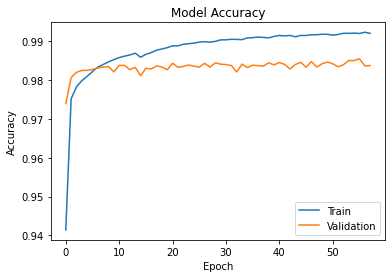

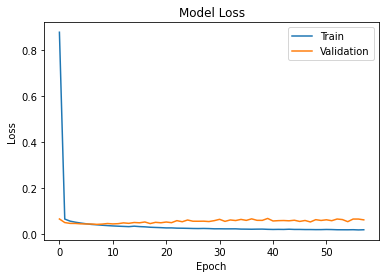

In [7]:
plot_history(history)

In [8]:
unet.evaluate(test_images, test_masks);

510/510 [==============================] - 6s 12ms/sample - loss: 0.0278 - accuracy: 0.9891


### $\bullet$ Training model using images with simple data augmentations and no distortions

In [9]:
# Setting up parameters used for training
number_epochs = 200
batch_size = 2
steps_per_epoch = np.ceil(len(train_images)/batch_size).astype(np.uint)
early_stopping = EarlyStopping(patience=80, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath=unet_data_augmented_save_path, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)

# Building Unet model.
unet = unet(images_shape, show_summary=False)

In [10]:
# Training
train_generator = make_train_generator(train_images, train_masks, batch_size=batch_size, custom_distortions=False)
history = unet.fit(train_generator, validation_data=(val_images, val_masks), steps_per_epoch=steps_per_epoch, batch_size=batch_size, epochs=number_epochs, callbacks=[early_stopping, model_checkpoint])

  ...
    to  
  ['...']
Train for 303 steps, validate on 96 samples
Epoch 1/200
303/303 [==============================] - 23s 74ms/step - loss: 0.3674 - accuracy: 0.9520 - val_loss: 0.0549 - val_accuracy: 0.9799
Epoch 2/200
303/303 [==============================] - 21s 68ms/step - loss: 0.0561 - accuracy: 0.9785 - val_loss: 0.0465 - val_accuracy: 0.9824
Epoch 3/200
303/303 [==============================] - 20s 67ms/step - loss: 0.0498 - accuracy: 0.9808 - val_loss: 0.0444 - val_accuracy: 0.9829
Epoch 4/200
303/303 [==============================] - 20s 67ms/step - loss: 0.0462 - accuracy: 0.9819 - val_loss: 0.0427 - val_accuracy: 0.9837
Epoch 5/200
303/303 [==============================] - 20s 67ms/step - loss: 0.0435 - accuracy: 0.9827 - val_loss: 0.0414 - val_accuracy: 0.9840
Epoch 6/200
303/303 [==============================] - 16s 53ms/step - loss: 0.0409 - accuracy: 0.9836 - val_loss: 0.0416 - val_accuracy: 0.9839
Epoch 7/200
303/303 [==============================] - 16s 54

Epoch 43/200
303/303 [==============================] - 16s 54ms/step - loss: 0.0216 - accuracy: 0.9910 - val_loss: 0.0544 - val_accuracy: 0.9853
Epoch 44/200
303/303 [==============================] - 16s 54ms/step - loss: 0.0214 - accuracy: 0.9910 - val_loss: 0.0477 - val_accuracy: 0.9846
Epoch 45/200
303/303 [==============================] - 16s 54ms/step - loss: 0.0213 - accuracy: 0.9911 - val_loss: 0.0514 - val_accuracy: 0.9846
Epoch 46/200
303/303 [==============================] - 16s 54ms/step - loss: 0.0208 - accuracy: 0.9913 - val_loss: 0.0505 - val_accuracy: 0.9848
Epoch 47/200
303/303 [==============================] - 16s 54ms/step - loss: 0.0213 - accuracy: 0.9911 - val_loss: 0.0592 - val_accuracy: 0.9851
Epoch 48/200
303/303 [==============================] - 16s 54ms/step - loss: 0.0208 - accuracy: 0.9912 - val_loss: 0.0450 - val_accuracy: 0.9853
Epoch 49/200
303/303 [==============================] - 16s 54ms/step - loss: 0.0209 - accuracy: 0.9913 - val_loss: 0.0567 -

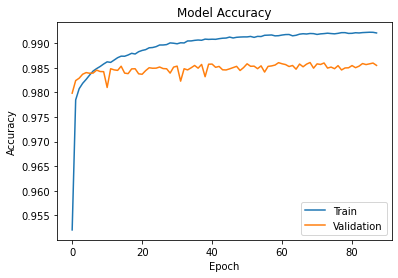

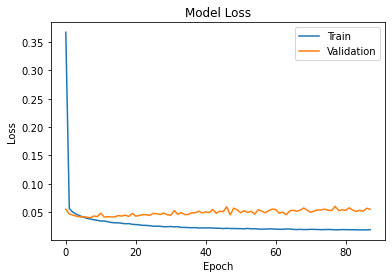

In [11]:
plot_history(history)

In [12]:
unet.evaluate(test_images, test_masks);

510/510 [==============================] - 4s 7ms/sample - loss: 0.0257 - accuracy: 0.9899


### $\bullet$ Training model using images with simple data augmentations as well as distortions

In [13]:
# Setting up parameters used for training
number_epochs = 200
batch_size = 2
steps_per_epoch = np.ceil(len(train_images)/batch_size).astype(np.uint)
early_stopping = EarlyStopping(patience=80, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath=unet_data_distorted_save_path, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)

# Building Unet model.
unet = unet(images_shape, show_summary=False)

In [14]:
# Training
train_generator = make_train_generator(train_images, train_masks, batch_size=batch_size, custom_distortions=True)
history = unet.fit(train_generator, validation_data=(val_images, val_masks), steps_per_epoch=steps_per_epoch, batch_size=batch_size, epochs=number_epochs, callbacks=[early_stopping, model_checkpoint])

  ...
    to  
  ['...']
Train for 303 steps, validate on 96 samples
Epoch 1/200
303/303 [==============================] - 22s 74ms/step - loss: 0.5609 - accuracy: 0.9016 - val_loss: 0.0937 - val_accuracy: 0.9694
Epoch 2/200
303/303 [==============================] - 16s 53ms/step - loss: 0.2095 - accuracy: 0.9277 - val_loss: 0.0888 - val_accuracy: 0.9668
Epoch 3/200
303/303 [==============================] - 16s 54ms/step - loss: 0.2069 - accuracy: 0.9277 - val_loss: 0.1029 - val_accuracy: 0.9548
Epoch 4/200
303/303 [==============================] - 21s 69ms/step - loss: 0.1910 - accuracy: 0.9327 - val_loss: 0.0649 - val_accuracy: 0.9749
Epoch 5/200
303/303 [==============================] - 16s 53ms/step - loss: 0.1999 - accuracy: 0.9293 - val_loss: 0.1026 - val_accuracy: 0.9653
Epoch 6/200
303/303 [==============================] - 16s 54ms/step - loss: 0.1795 - accuracy: 0.9372 - val_loss: 0.1029 - val_accuracy: 0.9693
Epoch 7/200
303/303 [==============================] - 16s 54

303/303 [==============================] - 17s 55ms/step - loss: 0.1692 - accuracy: 0.9455 - val_loss: 0.0795 - val_accuracy: 0.9824
Epoch 46/200
303/303 [==============================] - 16s 54ms/step - loss: 0.1539 - accuracy: 0.9519 - val_loss: 0.0692 - val_accuracy: 0.9820
Epoch 47/200
303/303 [==============================] - 16s 54ms/step - loss: 0.1684 - accuracy: 0.9461 - val_loss: 0.0728 - val_accuracy: 0.9821
Epoch 48/200
303/303 [==============================] - 16s 54ms/step - loss: 0.1671 - accuracy: 0.9467 - val_loss: 0.0706 - val_accuracy: 0.9803
Epoch 49/200
303/303 [==============================] - 16s 54ms/step - loss: 0.1669 - accuracy: 0.9464 - val_loss: 0.0696 - val_accuracy: 0.9827
Epoch 50/200
303/303 [==============================] - 16s 54ms/step - loss: 0.1736 - accuracy: 0.9437 - val_loss: 0.0694 - val_accuracy: 0.9835
Epoch 51/200
303/303 [==============================] - 17s 55ms/step - loss: 0.1647 - accuracy: 0.9477 - val_loss: 0.0676 - val_accuracy

303/303 [==============================] - 15s 50ms/step - loss: 0.1594 - accuracy: 0.9504 - val_loss: 0.0682 - val_accuracy: 0.9825
Epoch 99/200
303/303 [==============================] - 15s 51ms/step - loss: 0.1644 - accuracy: 0.9481 - val_loss: 0.0859 - val_accuracy: 0.9826
Epoch 100/200
303/303 [==============================] - 16s 52ms/step - loss: 0.1620 - accuracy: 0.9494 - val_loss: 0.0853 - val_accuracy: 0.9832
Epoch 101/200
303/303 [==============================] - 16s 51ms/step - loss: 0.1733 - accuracy: 0.9445 - val_loss: 0.0961 - val_accuracy: 0.9805
Epoch 102/200
303/303 [==============================] - 15s 51ms/step - loss: 0.1613 - accuracy: 0.9496 - val_loss: 0.0851 - val_accuracy: 0.9797
Epoch 103/200
303/303 [==============================] - 16s 51ms/step - loss: 0.1655 - accuracy: 0.9477 - val_loss: 0.0752 - val_accuracy: 0.9832
Epoch 104/200
303/303 [==============================] - 16s 52ms/step - loss: 0.1543 - accuracy: 0.9523 - val_loss: 0.0813 - val_acc

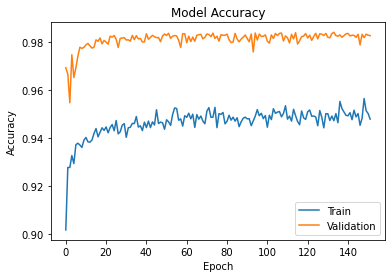

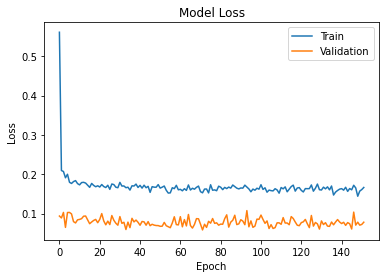

In [15]:
plot_history(history)

In [16]:
unet.evaluate(test_images, test_masks);

510/510 [==============================] - 4s 7ms/sample - loss: 0.0427 - accuracy: 0.9889
